## _Feature engineering exercises_

In [100]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

import wrangle as wr

1. **Load the tips dataset.**

a) Create a column named ```price_per_person```. This should be the ```total bill``` divided by the party ```size```.

In [152]:
# get the train data set from tips data set
tips, _, _ = wr.split_df(sns.load_dataset('tips'))

In [153]:
tips.shape

(136, 7)

In [154]:
tips.head(1)

,total_bill,tip,sex,smoker,day,time,size
73,25.28,5.0,Female,Yes,Sat,Dinner,2


In [155]:
# create price_per_person
tips['price_per_person'] = round((tips.total_bill / tips['size']), 2)

In [14]:
# create dummies for categorical variables

In [156]:
tips['sex'] = tips.sex.map({'Male':0, 'Female':1})
tips['smoker'] = tips.smoker.map({'Yes':1, 'No':0})
tips['time'] = tips.time.map({'Dinner' :1, 'Lunch':0})
tips['thur'] = np.where(tips.day == 'Thur', 1, 0)
tips['fri'] = np.where(tips.day == 'Fri', 1, 0)
tips['sat'] = np.where(tips.day == 'Sat', 1, 0)
tips['sun'] = np.where(tips.day == 'Sun', 1, 0)

b) Before using any of the methods discussed in the lesson, which features do you think would be most important for predicting the tip amount?

```total_bill``` should be the best predictor. I guess the time of the day will be the 2nd one

In [164]:
import matplotlib.pyplot as plt

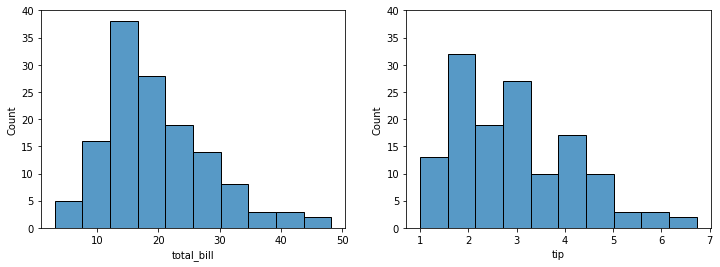

In [172]:
plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.histplot(data=tips, x='total_bill', bins=10)
plt.ylim(0, 40)
plt.subplot(122)
sns.histplot(data=tips, x='tip', bins=10)
plt.ylim(0, 40);

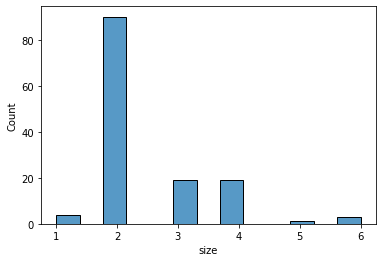

In [161]:
sns.histplot(data=tips, x='size');

In [158]:
#get the target variable
y = tips.tip

In [159]:
#get the data set to fit into the models
X = tips.drop(columns=['tip', 'day'])

In [118]:
from sklearn.preprocessing import MinMaxScaler

In [160]:
#scale the data
mm = MinMaxScaler()
tips.loc[:,['price_per_person']] = mm.fit_transform(tips[['price_per_person']])

In [173]:
mm1 = MinMaxScaler()
tips.loc[:,['total_bill']] = mm1.fit_transform(tips[['total_bill']])

In [174]:
mm2 = MinMaxScaler()
tips.loc[:,['size']] = mm1.fit_transform(tips[['size']])

In [175]:
X.head(1)

,total_bill,sex,smoker,time,size,price_per_person,thur,fri,sat,sun
73,25.28,1,1,1,2,12.64,0,0,1,0


c) Use ```select k best``` to select the top 2 features for predicting ```tip``` amount. What are they?

In [147]:
#SelectKBest(f_regression, k=2).fit_transform(X, y)
kbest = SelectKBest(f_regression, k=2)
kbest.fit(X, y)
X.columns[kbest.get_support()].tolist()

['total_bill', 'size']

In [61]:
# Best features from kbest -> total_bill, size
# after adding price_per_person -> total_bill and price_per_person

d) Use ```recursive feature elimination``` to select the top 2 features for ```tip amount```. What are they?

In [148]:
model = LinearRegression()
rfe = RFE(model, n_features_to_select=2)
rfe.fit(X, y)
X.columns[rfe.get_support()].tolist()

['total_bill', 'price_per_person']

In [48]:
# RFE picks 'size' and 'fri' (Friday) as the best estimators
# after adding price_per_person -> sun and price_per_person

e) Why do you think ```select k best``` and ```recursive feature elimination``` might give different answers for the top features? Does this change as you change the number of features you are selecting?

This to algorithms work differently. Select K best looks for strongest correlations, and RFE runs the model over and over again with different features and selects the best performing one

In [149]:
kbest3 = SelectKBest(f_regression, k=3)
kbest3.fit(X, y)

rfe3 = RFE(model, n_features_to_select=3)
rfe3.fit(X, y)

print('Nuber of features = 3')
print(f'K-best features: {X.columns[kbest3.get_support()].tolist()}')
print(f'RFE features: {X.columns[rfe3.get_support()].tolist()}')

Nuber of features = 3
K-best features: ['total_bill', 'size', 'price_per_person']
RFE features: ['total_bill', 'price_per_person', 'sun']


In [150]:
kbest4 = SelectKBest(f_regression, k=4)
kbest4.fit(X, y)

rfe4 = RFE(model, n_features_to_select=4)
rfe4.fit(X, y)

print('Nuber of features = 4')
print(f'K-best features: {X.columns[kbest4.get_support()].tolist()}')
print(f'RFE features: {X.columns[rfe4.get_support()].tolist()}')

Nuber of features = 4
K-best features: ['total_bill', 'size', 'price_per_person', 'sun']
RFE features: ['total_bill', 'time', 'price_per_person', 'sun']


In [151]:
pd.DataFrame(
{
    'rfe_2': rfe.ranking_
},index = X.columns) 

,rfe_2
total_bill,1
sex,7
smoker,5
time,3
size,8
price_per_person,1
thur,6
fri,4
sat,9
sun,2


In [115]:
pd.DataFrame(
{
    'rfe_3': rfe3.ranking_
},index = X.columns)

,rfe_3
total_bill,2
sex,5
smoker,4
time,1
size,7
price_per_person,6
thur,3
fri,1
sat,8
sun,1


In [116]:
pd.DataFrame(
{
    'rfe_4': rfe4.ranking_
},index = X.columns)

,rfe_4
total_bill,1
sex,4
smoker,3
time,1
size,6
price_per_person,5
thur,2
fri,1
sat,7
sun,1


2. **Write a function named ```select_kbest``` that takes in the predictors (```X```), the target (```y```), and the number of features to select (```k```) and returns the names of the top k selected features based on the ```SelectKBest class```. Test your function with the ```tips``` dataset. You should see the same results as when you did the process manually.**

In [82]:
def select_kbest(X, y, k):
    '''
    the function accepts the X_train data set, y_train array and k-number of features to select
    runs the SelectKBest algorithm and returns the list of features to be selected for the modeling
    !KBest doesn't depend on the model
    '''
    kbest = SelectKBest(f_regression, k=k)
    kbest.fit(X, y)
    return X.columns[kbest.get_support()].tolist()

In [83]:
select_kbest(X, y, 3)

['total_bill', 'size', 'price_per_person']

3. **Write a function named ```rfe``` that takes in the predictors, the target, and the number of features to select. It should return the top k features based on the ```RFE class```. Test your function with the ```tips``` dataset. You should see the same results as when you did the process manually.**

In [85]:
def rfe(X, y, k):
    '''
    The function accepts the X_train data set, y_train array and k-number of features to select
    runs the RFE algorithm and returns the list of features to be selected for the modeling
    !RFE depends on the model.
    This function uses Linear regression
    '''
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=k)
    rfe.fit(X, y)
    return X.columns[rfe.get_support()].tolist()

In [87]:
rfe(X, y, 3)

['time', 'sun', 'price_per_person']

In [86]:
def rfe_model(X, y, model, k):
    '''
    The function accepts the X_train data set, y_train array,
    model (created with hyperparameters) and k-number of features to select
    runs the RFE algorithm and returns the list of features to be selected for the modeling
    '''
    rfe = RFE(model, n_features_to_select=k)
    rfe.fit(X, y)
    return X.columns[rfe.get_support()].tolist()

In [88]:
rfe_model(X, y, model, 3)

['time', 'sun', 'price_per_person']

4. **Load the ```swiss``` dataset and use all the other features to predict Fertility. Find the top 3 features using both ```select k best``` and ```recursive feature elimination``` (use the functions you just built to help you out).**

In [17]:
from pydataset import data

In [89]:
swiss = data('swiss')

In [90]:
swiss.head(1)

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2


In [91]:
swiss, _, _ = wr.split_df(swiss)

In [92]:
y_swiss = swiss.Fertility

In [94]:
X_swiss = swiss.drop(columns='Fertility')

In [95]:
X_swiss.head(1)

,Agriculture,Examination,Education,Catholic,Infant.Mortality
Le Locle,16.7,22,13,11.22,18.9


In [96]:
select_kbest(X_swiss, y_swiss, 3)

['Examination', 'Education', 'Catholic']

In [97]:
rfe(X_swiss, y_swiss, 3)

['Agriculture', 'Education', 'Infant.Mortality']